<a href="https://colab.research.google.com/github/hsallrounder/Cognitive-Analytics-Workshop-2/blob/main/Day2_ECG_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf

In [ ]:
# source: https://drive.google.com/file/d/1yVf7vQzZdRZGv8veAZDEiQodHAh8qA_R/view?usp=drive_link
# use '!' sign for linux commands
# !gdown '{fileID}' -> command used to download anu file from gdrive
!gdown '1yVf7vQzZdRZGv8veAZDEiQodHAh8qA_R'

Downloading...
From: https://drive.google.com/uc?id=1yVf7vQzZdRZGv8veAZDEiQodHAh8qA_R
To: /content/ecg_tf_anomaly_detection.csv
100% 7.88M/7.88M [00:00<00:00, 121MB/s]


In [ ]:
# dataframe to numpy array
# ecg_df.to_numpy()
# ecg.values

In [ ]:
ecg_df=pd.read_csv('ecg_tf_anomaly_detection.csv',header=None) #load data
ecg_data,ecg_labels = ecg_df.values[:,:-1],ecg_df.values[:,-1] # get data and labels as array
# scale values between 0 and 1
# ecg_data = (ecg_data-ecg_data.min())/(ecg_data-ecg_data.max()-ecg_data-ecg_data.min()) # by numpy
ecg_data = (ecg_data-tf.reduce_min(ecg_data))/(tf.reduce_max(ecg_data)-tf.reduce_min(ecg_data))
ecg_data =tf.cast(ecg_data,dtype=tf.float32,name=None) # type cast to float32 bit
ecg_labels = tf.cast(ecg_labels,dtype=tf.uint8,name=None) # type cast to unsigned int
print('Maximum value in data:',tf.reduce_max(ecg_data)) # maximum value in data
print('Minimun value in data:',tf.reduce_min(ecg_data)) # minimum value in data
print('Shape of data:',ecg_data.shape) # shape of the data
print('Unique labels:',set(ecg_labels.numpy().flatten())) # unique labes ()

Maximum value in data: tf.Tensor(1.0, shape=(), dtype=float32)
Minimun value in data: tf.Tensor(0.0, shape=(), dtype=float32)
Shape of data: (4998, 140)
Unique labels: {0, 1}


In [ ]:
decoder:dict={0:'abnormal',1:'normal'} # make a decoder dictionary

In [ ]:
ecg_dataset = tf.data.Dataset.from_tensor_slices((ecg_data,ecg_labels),name='ecg_data')
print('Total samples:',ecg_dataset.cardinality()) # total number of sets in data
print('Element specific in dataset:',ecg_dataset.element_spec) # type of element in data pipelines

Total samples: tf.Tensor(4998, shape=(), dtype=int64)
Element specific in dataset: (TensorSpec(shape=(140,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))


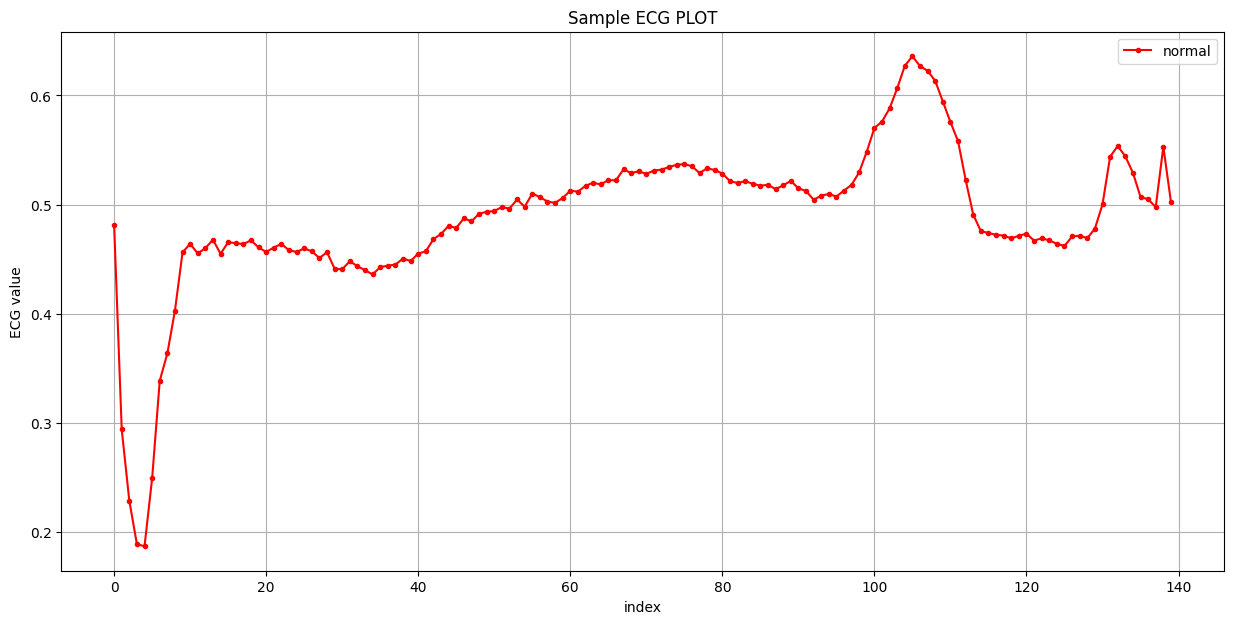

In [ ]:
for data,label in  ecg_dataset.take(1):break # take a sample from data
plt.figure(figsize=(15,7))
plt.plot(data,color='r',marker='.',label=decoder[label.numpy()])
plt.xlabel('index'),plt.ylabel('ECG value'),plt.grid()
plt.title('Sample ECG PLOT'),plt.legend()
plt.show()

In [ ]:
batch_size:int = 32
total_samples:int = 4998
ecg_dataset = ecg_dataset.batch(batch_size=batch_size,
                                num_parallel_calls=tf.data.AUTOTUNE).prefetch(1024)

In [ ]:
train_ds = ecg_dataset.take(int(total_samples*0.7/batch_size)).shuffle(1024)
valid_ds = ecg_dataset.skip(int(total_samples*0.7/batch_size)).take(
    int(total_samples*0.2/batch_size))
test_ds = ecg_dataset.skip(int(total_samples*0.9/batch_size)).take(
    int(total_samples*0.1/batch_size))

In [ ]:
inputs=tf.keras.layers.Input(shape=(140,),
                             batch_size=None,name='inputs')
model_x=tf.keras.layers.Dense(128,activation='relu')(inputs)
model_x=tf.keras.layers.Dense(64,activation='relu')(model_x)
model_x=tf.keras.layers.Dense(32,activation='relu')(model_x)
outputs=tf.keras.layers.Dense(1,activation=None)(model_x)

model=tf.keras.Model(inputs=[inputs],outputs=[outputs],name='ecg_clf')
model.summary()

Model: "ecg_clf"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 140)]             0         
                                                                 
 dense_4 (Dense)             (None, 128)               18048     
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 28417 (111.00 KB)
Trainable params: 28417 (111.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# make compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=tf.keras.metrics.BinaryAccuracy())

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',min_delta=0,patience=10,verbose=1,
    mode='auto',baseline=None,restore_best_weights=True)

history = model.fit(train_ds,batch_size=batch_size,epochs=10,verbose='auto',
          validation_data=valid_ds,shuffle=True,callbacks=[early_stopping])

Epoch 1/10
109/109 [==============================] - 1s 4ms/step - loss: 0.4783 - binary_accuracy: 0.8162 - val_loss: 1.3537 - val_binary_accuracy: 0.0000e+00
Epoch 2/10
109/109 [==============================] - 0s 4ms/step - loss: 0.4514 - binary_accuracy: 0.8426 - val_loss: 0.8271 - val_binary_accuracy: 0.9345
Epoch 3/10
109/109 [==============================] - 0s 3ms/step - loss: 0.4227 - binary_accuracy: 0.8483 - val_loss: 1.2617 - val_binary_accuracy: 0.0000e+00
Epoch 4/10
109/109 [==============================] - 0s 3ms/step - loss: 0.4337 - binary_accuracy: 0.8535 - val_loss: 1.5927 - val_binary_accuracy: 0.0000e+00
Epoch 5/10
109/109 [==============================] - 0s 4ms/step - loss: 0.3064 - binary_accuracy: 0.8997 - val_loss: 1.5331 - val_binary_accuracy: 0.0544
Epoch 6/10
109/109 [==============================] - 0s 3ms/step - loss: 0.1977 - binary_accuracy: 0.9401 - val_loss: 0.2415 - val_binary_accuracy: 0.9526
Epoch 7/10
109/109 [==============================] 

In [ ]:
pd.DataFrame(history.history).head() # first five epochs

,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0.478282,0.816227,1.353747,0.000000
1,0.451367,0.842603,0.827149,0.934476
2,0.422702,0.848337,1.261670,0.000000
3,0.433719,0.853498,1.592692,0.000000
4,0.306393,0.899656,1.533102,0.054435


In [ ]:
pd.DataFrame(history.history).tail() # last five epochs

,loss,binary_accuracy,val_loss,val_binary_accuracy
5,0.197693,0.940080,0.241523,0.952621
6,0.164292,0.948968,0.464564,0.888105
7,0.107014,0.970757,0.874229,0.776210
8,0.113313,0.966743,0.403275,0.895161
9,0.095787,0.968463,0.273731,0.918347


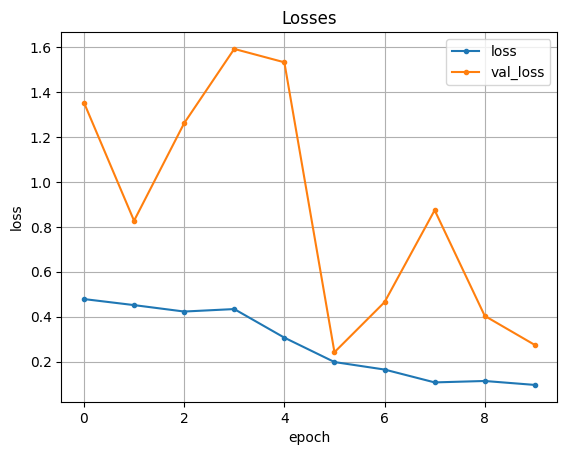

In [ ]:
# make plot losses
pd.DataFrame(history.history)[['loss','val_loss']].plot(marker='.')
plt.grid(),plt.title('Losses'),plt.xlabel('epoch'),plt.ylabel('loss')
plt.show()

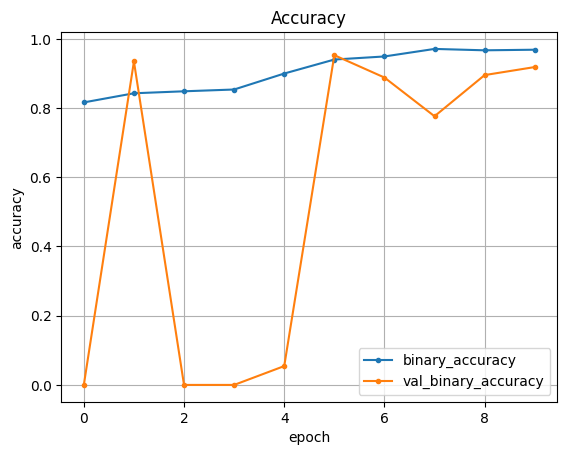

In [ ]:
# make plot accuracy
pd.DataFrame(history.history)[['binary_accuracy','val_binary_accuracy']].plot(marker='.')
plt.grid(),plt.title('Accuracy'),plt.xlabel('epoch'),plt.ylabel('accuracy')
plt.show()

In [ ]:
results:dict = model.evaluate(train_ds,return_dict=True)
results

109/109 [==============================] - 0s 1ms/step - loss: 0.0735 - binary_accuracy: 0.9808


{'loss': 0.07345953583717346, 'binary_accuracy': 0.9807912707328796}

In [ ]:
ecg_df = pd.read_csv('ecg_tf_anomaly_detection.csv',header=None) #load data
ecg_df.head()


,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [ ]:
abnormal_ecg:pd.DataFrame = ecg_df[ecg_df.iloc[:,-1]==0] # abnormal
normal_ecg:pd.DataFrame = ecg_df[ecg_df.iloc[:,-1]==1] # normal

In [ ]:
normal_ecg=normal_ecg.iloc[:,:-1].values # to numpy array
abnormal_ecg=abnormal_ecg.iloc[:,:-1].values # to numpy array

In [ ]:
normal_ecg = (normal_ecg-tf.reduce_min(normal_ecg))/(tf.reduce_max(normal_ecg)-tf.reduce_min(normal_ecg))
abnormal_ecg = (abnormal_ecg-tf.reduce_min(abnormal_ecg))/(tf.reduce_max(abnormal_ecg)-tf.reduce_min(abnormal_ecg))

In [ ]:
normal_ecg = tf.cast(normal_ecg,dtype=tf.float32,name=None)
abnormal_ecg = tf.cast(abnormal_ecg,dtype=tf.float32,name=None)

In [ ]:
abnormal_dataset = tf.data.Dataset.from_tensor_slices((abnormal_ecg),name='abnormal_data')
print('Total samples:',abnormal_dataset.cardinality()) # total number of sets in data
print('Element specific in dataset:',abnormal_dataset.element_spec) # type of element in data pipelines

Total samples: tf.Tensor(2079, shape=(), dtype=int64)
Element specific in dataset: TensorSpec(shape=(140,), dtype=tf.float32, name=None)


In [ ]:
# train on normal and then check with abnormal